Read Files

In [17]:
import numpy as np
import random
from typing import List, Tuple
import time

def read_vrp_file(filepath: str):
    data = {
        "name": None,
        "dimension": None,
        "capacity": None,
        "customers": {},   # now contains x,y,demand
        "depot": None,
        "distance_matrix": None
    }

    coordinates = {}
    demands = {}

    section = None
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("EOF"):
                continue

            # Metadata
            if line.startswith("NAME"):
                data["name"] = line.split(":")[1].strip()
            elif line.startswith("DIMENSION"):
                data["dimension"] = int(line.split(":")[1].strip())
            elif line.startswith("CAPACITY"):
                data["capacity"] = int(line.split(":")[1].strip())
            elif line.startswith("EDGE_WEIGHT_TYPE"):
                data["edge_weight_type"] = line.split(":")[1].strip()

            # Sections
            elif line.startswith("NODE_COORD_SECTION"):
                section = "coords"
                continue
            elif line.startswith("DEMAND_SECTION"):
                section = "demand"
                continue
            elif line.startswith("DEPOT_SECTION"):
                section = "depot"
                continue

            # Parse sections
            elif section == "coords":
                parts = line.split()
                node, x, y = int(parts[0]), float(parts[1]), float(parts[2])
                coordinates[node] = (x, y)

            elif section == "demand":
                parts = line.split()
                node, demand = int(parts[0]), int(parts[1])
                demands[node] = demand

            elif section == "depot":
                node = int(line)
                if node == -1:  # End of depot section
                    section = None
                else:
                    data["depot"] = node

    # Merge coordinates and demands into customers
    for node, (x, y) in coordinates.items():
        demand = demands.get(node, 0)
        data["customers"][node] = (x, y, demand)

    return data


data = read_vrp_file("content/A-n32-k5.vrp")
data['customers']



{1: (82.0, 76.0, 0),
 2: (96.0, 44.0, 19),
 3: (50.0, 5.0, 21),
 4: (49.0, 8.0, 6),
 5: (13.0, 7.0, 19),
 6: (29.0, 89.0, 7),
 7: (58.0, 30.0, 12),
 8: (84.0, 39.0, 16),
 9: (14.0, 24.0, 6),
 10: (2.0, 39.0, 16),
 11: (3.0, 82.0, 8),
 12: (5.0, 10.0, 14),
 13: (98.0, 52.0, 21),
 14: (84.0, 25.0, 16),
 15: (61.0, 59.0, 3),
 16: (1.0, 65.0, 22),
 17: (88.0, 51.0, 18),
 18: (91.0, 2.0, 19),
 19: (19.0, 32.0, 1),
 20: (93.0, 3.0, 24),
 21: (50.0, 93.0, 8),
 22: (98.0, 14.0, 12),
 23: (5.0, 42.0, 4),
 24: (42.0, 9.0, 8),
 25: (61.0, 62.0, 24),
 26: (9.0, 97.0, 24),
 27: (80.0, 55.0, 2),
 28: (57.0, 69.0, 20),
 29: (23.0, 15.0, 15),
 30: (20.0, 70.0, 2),
 31: (85.0, 60.0, 14),
 32: (98.0, 5.0, 9)}

Create Individuals

In [18]:
customers = [cust for key, cust in data['customers'].items()]
print(customers)
vehicleCapacity = data['capacity']
depot = data['depot']-1

# hardcoding vehicles, not good we need change

def vehicleCheck(vehicle, customer=None):
  usedSpace = 0
  for cust in vehicle:
    usedSpace += customers[cust][2]

  if customer is not None:
    return usedSpace + customer[2] <= vehicleCapacity
  else:
    return usedSpace <= vehicleCapacity

def create_individual(vehicles):
    # Step 2: Remove one random element
    individual = [[] for _ in range(vehicles)]

    for idx in range(1,len(customers)):
        customer = customers[idx]
        chosen_vehicle = random.randint(0, vehicles - 1)
        if vehicleCheck(individual[chosen_vehicle],customer):
            individual[chosen_vehicle].append(idx)
        else:
            individual.append([idx])

    return individual

create_individual(5)

[(82.0, 76.0, 0), (96.0, 44.0, 19), (50.0, 5.0, 21), (49.0, 8.0, 6), (13.0, 7.0, 19), (29.0, 89.0, 7), (58.0, 30.0, 12), (84.0, 39.0, 16), (14.0, 24.0, 6), (2.0, 39.0, 16), (3.0, 82.0, 8), (5.0, 10.0, 14), (98.0, 52.0, 21), (84.0, 25.0, 16), (61.0, 59.0, 3), (1.0, 65.0, 22), (88.0, 51.0, 18), (91.0, 2.0, 19), (19.0, 32.0, 1), (93.0, 3.0, 24), (50.0, 93.0, 8), (98.0, 14.0, 12), (5.0, 42.0, 4), (42.0, 9.0, 8), (61.0, 62.0, 24), (9.0, 97.0, 24), (80.0, 55.0, 2), (57.0, 69.0, 20), (23.0, 15.0, 15), (20.0, 70.0, 2), (85.0, 60.0, 14), (98.0, 5.0, 9)]


[[6, 14, 20, 24, 27, 28, 29, 30],
 [7, 8],
 [1, 4, 11, 15, 16, 22, 26],
 [5, 9, 10, 12, 17, 19],
 [2, 3, 13, 18, 23, 25],
 [21],
 [31]]

Distance

In [19]:
# Euclidean distance between two customers
def euclidean_distance(cust1, cust2):
    x1, y1 = cust1[0], cust1[1]
    x2, y2 = cust2[0], cust2[1]
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5

# Create distance matrix
def create_distance_matrix():
    n = len(customers)
    distance_matrix = np.zeros((n, n))  # n x n matrix

    for i in range(len(customers)):
        for j in range(len(customers)):
            distance_matrix[i][j] = euclidean_distance(customers[i], customers[j])
    # print(customers)
    # print(distance_matrix)
    return distance_matrix


def distance_per_route(route):
  depot_route = [depot] + route + [depot]
  distance = 0

  for customeridx in range(len(depot_route)-1):
    # print(depot_route[customeridx],depot_route[customeridx+1])
    distance+=distance_matrix[depot_route[customeridx]][depot_route[customeridx+1]]

  return distance

# Example usage
distance_matrix = create_distance_matrix()

individuals = create_individual(5)

print(distance_per_route(individuals[0]))

404.1479099629652


Objective 1

In [20]:
def objective1(solution):
  total_distance = 0
  for route in solution:
    total_distance += distance_per_route(route)
  return total_distance

Objective 2

In [21]:
def objective2(solution):
  total_distance = objective1(solution)
  num_vehicles = len(solution)
  average_distance = total_distance/num_vehicles
  sum = 0
  for route in solution:
    distance = distance_per_route(route)
    sum += (distance-average_distance)**2

  return (sum*1/num_vehicles)**0.5


Mutation

In [22]:
def swap_mutation(individual):
    vehicle = random.choice([v for v in individual if len(v) > 1])
    i, j = random.sample(range(len(vehicle)), 2)
    vehicle[i], vehicle[j] = vehicle[j], vehicle[i]
    return individual


def relocation_mutation(individual):
    # pick a non-empty vehicle as source
    from_vehicle = random.choice([v for v in individual if v])
    customer = from_vehicle.pop(random.randrange(len(from_vehicle)))

    # pick a different vehicle as target
    candidates = [v for v in individual if v is not from_vehicle]
    to_vehicle = random.choice(candidates)

    # Check if car has space for customer
    if vehicleCheck(to_vehicle,customers[customer]):
        # print(customers[customer])
        # print(customer)
        # print(to_vehicle)
        # insert at random position
        insert_pos = random.randint(0, len(to_vehicle))
        to_vehicle.insert(insert_pos, customer)
    # If there isnt space in the car, create new one
    else:
        individual.append([customer])

    return individual

Crossover

In [23]:
def order_crossover(parent1, parent2):
    number_of_customers = sum(len(r) for r in parent1)

    # 1. Create lists without vehicle format from parents
    parent1_to_list = [c for route in parent1 for c in route]
    parent2_to_list = [c for route in parent2 for c in route]

    # 2. Pick random crossover points and add to child
    start, end = sorted(random.sample(range(len(parent1_to_list)), 2))
    child_list = [None]*number_of_customers
    child_list[start:end+1] = parent1_to_list[start:end+1]

    # 3. Fill remaining customers from parent2 in order
    pointer = (end + 1) % len(child_list)
    for c in parent2_to_list:
        if c not in child_list:
            child_list[pointer] = c
            pointer = (pointer + 1) % len(child_list)

    # 4. Split child list into vehicle routes based on parent1 format
    child = []

    index_parent_vehicle_length = 0
    index_child_vehicle_length = 0
    counter = 0
    child.append([])
    for customer in child_list:

        if counter >= len(parent1[index_parent_vehicle_length]):
          index_parent_vehicle_length+=1
          index_child_vehicle_length+=1
          child.append([])
          counter = 0
        elif not vehicleCheck(child[index_child_vehicle_length],customers[customer]):
          index_child_vehicle_length+=1
          child.append([])

        counter+=1
        child[index_child_vehicle_length].append(customer)

    # print("Output:")
    return child



Main method

In [24]:
class VEGA:
    """
    Vector Evaluated Genetic Algorithm (VEGA) implementation.
    This class implements VEGA for solving multi-objective optimization problems.
    """

    def __init__(self, pop_size: int, num_objectives: int, gene_size: int,
                 crossover_rate: float, mutation_rate: float):
        """
        Initialize the VEGA.

        Args:
            pop_size (int): Size of the population. Should be divisible by num_objectives.
            num_objectives (int): Number of objectives to optimize.
            gene_size (int): Number of genes in each individual.
            crossover_rate (float): Probability of crossover occurring.
            mutation_rate (float): Probability of mutation for each gene.
        """
        assert pop_size % num_objectives == 0, "Population size should be divisible by number of objectives"
        self.pop_size = pop_size
        self.num_objectives = num_objectives
        self.subpop_size = pop_size // num_objectives
        self.gene_size = gene_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.population = self.initialize_population()
    
    def population_objectives(self):
        """Return objective array F (N x 2) for current population."""
        import numpy as np
        return np.array([self.evaluate_fitness(ind) for ind in self.population], dtype=float)
    
    def initialize_population(self):
        """
        Initialize a random population.

        Returns:
            np.ndarray: A 2D array where each row represents an individual.
        """
        return [create_individual(vehicles=5) for _ in range(self.pop_size)]


    def evaluate_fitness(self, individual):
        """
        Evaluate the fitness of an individual.
        This is a placeholder and should be replaced with actual objective functions.

        Args:
            individual (np.ndarray): The individual to evaluate.

        Returns:
            List[float]: A list of fitness values, one for each objective.
        """
        return [objective1(individual),objective2(individual)]


    def vega_selection(self, fitness_values):
        """
        Perform VEGA selection by creating sub-populations based on each objective.

        Args:
            fitness_values (np.ndarray): Fitness values for the entire population.

        Returns:
            np.ndarray: Combined selected individuals from all sub-populations.
        """
        selected_indices = []

        for obj in range(self.num_objectives):
            # Sort indices based on current objective
            sorted_indices = sorted(range(len(fitness_values)), key=lambda i: fitness_values[i][obj])
            # Select top subpop_size indices
            top_indices = sorted_indices[:self.subpop_size]
            selected_indices.extend(top_indices)

        # Retrieve selected individuals
        selected_population = [self.population[i] for i in selected_indices]
        return selected_population

    def crossover(self, parent1, parent2):
        """
        Perform crossover between two parents.

        Args:
            parent1 (np.ndarray): First parent.
            parent2 (np.ndarray): Second parent.

        Returns:
            np.ndarray: Child produced by crossover.
        """
        if np.random.rand() < self.crossover_rate:
            return order_crossover(parent1,parent2)
        else:
          return parent1

    def mutate(self, individual):
        """
        Perform mutation on an individual.

        Args:
            individual (np.ndarray): The individual to mutate.

        Returns:
            np.ndarray: The mutated individual.
        """
        chance = random.random()
        if chance <= 0.1:  # 10% mutation rate for demonstration
          if chance < 0.05: # 50% of each mutation type
            relocation_mutation(individual)
          else: swap_mutation(individual)
        return individual

    def run(self, generations: int):
        """
        Run the VEGA for a specified number of generations.

        Args:
            generations (int): Number of generations to run.

        Returns:
            np.ndarray: The final population.
        """
        for i in range(generations):
            # print(self.population)
            # print("Generation:",i)
            fitness_values = [self.evaluate_fitness(ind) for ind in self.population]

            # Perform VEGA selection
            selected_population = self.vega_selection(fitness_values)
            # print(selected_population)

            # Create new population through crossover and mutation
            new_population = []
            while len(new_population) < self.pop_size:
                parent_indices = random.sample(range(len(selected_population)), 2)

                # Get the two parents from the list
                parent1 = selected_population[parent_indices[0]]
                parent2 = selected_population[parent_indices[1]]

                child = self.crossover(parent1, parent2)
                child = self.mutate(child)
                new_population.append(child)

            self.population = new_population

        return self.population

# # Usage example
vega = VEGA(pop_size=100, num_objectives=2, gene_size=10, crossover_rate=0.8, mutation_rate=0.1)
final_population = vega.run(generations=500)

# # Final spread calculation
# final_delta = vega.spread_delta_current_front()
# print("Final Spread (Δ):", final_delta)


In [25]:
def dominates(x,y):
    return all(x <= y for x, y in zip(a, b)) and any(x < y for x, y in zip(a, b))

In [26]:
def nondominated_points(points):
    points = np.array(points)
    nondominated_points = []
    for i, p in enumerate(points):
        dominated = False
        for j, q in enumerate(points):
            if i != j and all(q <= p) and any(q < p):
                dominated = True
                break
        if not dominated:
            nondominated_points.append(p)
    return np.array(nondominated_points)

In [ ]:
def hypervolume(pop,pareto_front):
    # Remove duplicates
    unique_pop = np.unique(pop, axis=0)
    unique_front = np.unique(pareto_front, axis=0)

    # Normalize to [0,1]
    mins = unique_pop.min(axis=0)
    maxs = unique_pop.max(axis=0)
    diff = np.where(maxs > mins, maxs - mins, 1.0)
    normalized_front = (unique_front - mins) / diff

    # Reference at [1,1]
    ref_point = np.array([1.0, 1.0])

    # Sort front by first objective
    normalized_front = normalized_front[np.argsort(normalized_front[:, 0])]

    hv = 0.0
    prev_f1 = ref_point[0]

    for f1, f2 in normalized_front[::-1]:  # iterate worst to best f1
        width = prev_f1 - f1
        height = ref_point[1] - f2
        hv += width * height
        prev_f1 = f1

    return hv


In [35]:
def spread_delta(points, sort_by=0):
    """
    Spread (Δ) for 2-objective minimization (NSGA-II).
    points: (N,2) array of non-dominated points.
    """
    
    # Normalize objectives for distance-based metrics
    unique_front_objs = np.unique(points, axis=0)

    mins = unique_front_objs.min(axis=0)
    maxs = unique_front_objs.max(axis=0)
    diff  = np.where(maxs > mins, maxs - mins, 1.0)   # avoid divide-by-zero
    normalized_front_objs = (unique_front_objs - mins) / diff



    # sort along one objective to walk the front
    normalized_front_objs = normalized_front_objs[np.argsort(normalized_front_objs[:, sort_by])]

    diffs = np.linalg.norm(normalized_front_objs[1:] - normalized_front_objs[:-1], axis=1)
    
    mean_diff = float(np.mean(diffs)) if len(diffs) else 0.0

    numerator = float(np.sum(np.abs(diffs - mean_diff)))
    denominator = (len(normalized_front_objs) - 1) * mean_diff
    return (numerator / denominator) if denominator != 0.0 else 0.0

In [37]:
objectives = np.array([[objective1(solution),objective2(solution)] for solution in final_population])

pareto_front= nondominated_points(objectives)
print(objectives)
hv = hypervolume(objectives,pareto_front)
print(hv)
spread = spread_delta(pareto_front)
print(spread)

[[2037.18598005   54.35432111]
 [2242.25309528   51.27762687]
 [2335.93130438   44.30087189]
 [1825.24447809   26.32316069]
 [1986.51967491   57.10020908]
 [1933.06999384   62.16395502]
 [2089.93750051   23.37075208]
 [1893.4389742    31.0955747 ]
 [2143.28186504   71.21098515]
 [2092.66631439   63.95842582]
 [2399.33220804  100.00703144]
 [2369.88431688   32.1555526 ]
 [1992.51380761   80.25212944]
 [2340.66858997   45.71421327]
 [2127.14506741   58.92450902]
 [2193.56555359   82.9389849 ]
 [2250.14174019   36.13636192]
 [2159.87520149   41.00603427]
 [2035.7164022    40.75809182]
 [1891.58798461   48.90228402]
 [2288.98761079   54.2728303 ]
 [2198.67981502   62.07443534]
 [1932.21197678   47.0087773 ]
 [2144.9532215    80.63645132]
 [2125.40344997   58.08883142]
 [1999.58206559   82.341422  ]
 [1989.85276303   65.98948613]
 [2217.40898035   62.35222539]
 [2127.70902661   44.90242596]
 [2041.06401771   66.95502936]
 [1826.91140247   51.00886036]
 [2081.11795267   41.00325614]
 [1990.9

In [43]:
total_Spread = []
total_Hypervolume = []
total_Runtime = []

min_spread = float("inf")
max_spread = 0

min_hypervolume = float("inf")
max_hypervolume = 0

for i in range(20):
    start_time = time.time()
    
    vega = VEGA(pop_size=100, num_objectives=2, gene_size=10, crossover_rate=0.8, mutation_rate=0.1)
    final_population = vega.run(generations=500)


    run_time = time.time() - start_time
    total_Runtime.append(run_time)

    points = np.array([[objective1(solution),objective2(solution)] for solution in final_population])

    pareto_front= nondominated_points(points)

    # print(points)
    delta = spread_delta(pareto_front, sort_by=0)
    total_Spread.append(delta)
    if delta < min_spread: min_spread = delta
    if delta > max_spread: max_spread = delta

    hv = hypervolume(points,pareto_front)
    total_Hypervolume.append(hv)
    if hv < min_hypervolume: min_hypervolume = hv
    if hv > max_hypervolume: max_hypervolume = hv

    print(f"Run {i+1}")
    print(f"  Spread (Δ): {delta:.4f}")
    print(f"  Hypervolume (HV): {hv:.4f}")

avg_Spread = np.mean(total_Spread)
avg_Hypervolume = np.mean(total_Hypervolume)
avg_Time = np.mean(total_Runtime)

print("\nAverages across 20 runs: ")
print(f"Average spread: {avg_Spread}")
print(f"Average hypervolume: {avg_Hypervolume}")
print(f"Average runtime: {avg_Time}")

print("\nHighest spread and lowest spread:")
print(f"Highest spread: {max_spread}")
print(f"Lowest spread: {min_spread}")

print("\nHighest hypervolume and lowest hypervolume")
print(f"Highest hypervolume: {max_hypervolume}")
print(f"Lowest hypervolume: {min_hypervolume}")

Run 1
  Spread (Δ): 0.2890
  Hypervolume (HV): 0.9807
Run 2
  Spread (Δ): 0.3558
  Hypervolume (HV): 0.9621


KeyboardInterrupt: 

Visual Solution

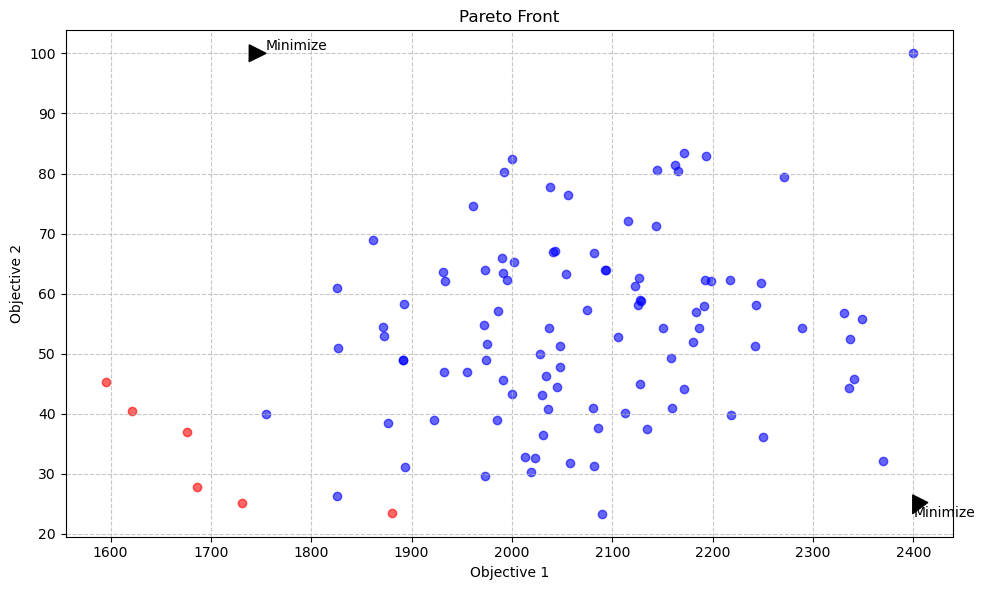

In [44]:
import matplotlib.pyplot as plt

# Assuming pareto_front is already defined
x = [solution[0] for solution in objectives]
y = [solution[1] for solution in objectives]

w = [solution[0] for solution in pareto_front]
v = [solution[1] for solution in pareto_front]
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c='blue', alpha=0.6)
plt.scatter(w, v, c='red', alpha=0.6)

plt.title('Pareto Front')
plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.grid(True, linestyle='--', alpha=0.7)

plt.annotate('Minimize', xy=(min(x), max(y)), xytext=(min(x)-0.5, max(y)+0.5),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Minimize', xy=(max(x), min(y)), xytext=(max(x)+0.5, min(y)-0.5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()

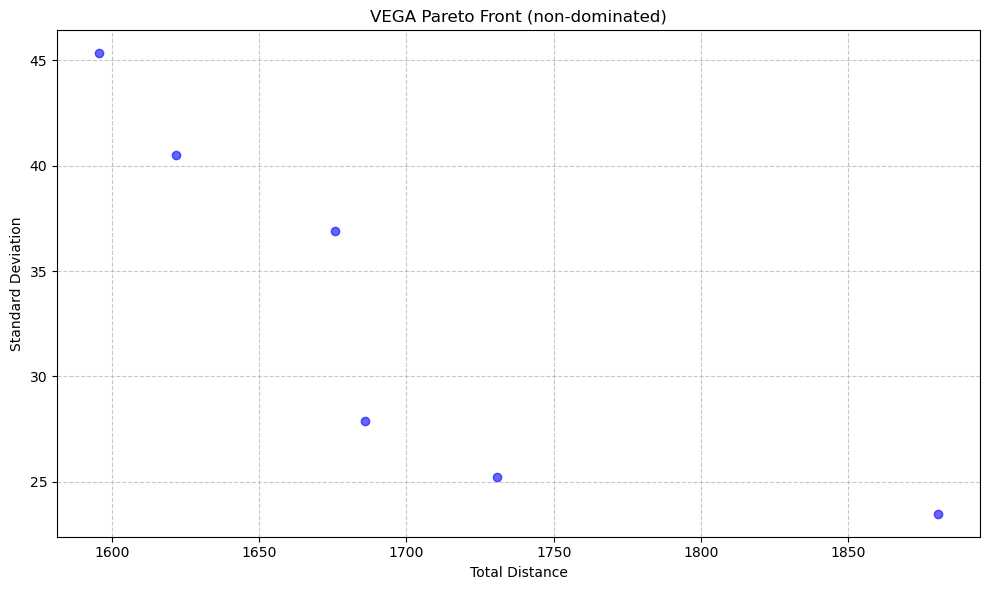

In [45]:
# Pareto front scatter for VEGA (like NSGA-II)
import matplotlib.pyplot as plt

F = np.array([vega.evaluate_fitness(ind) for ind in final_population], dtype=float)
front = nondominated_points(F)

x = front[:, 0] if len(front) else []
y = front[:, 1] if len(front) else []

plt.figure(figsize=(10, 6))
plt.scatter(x, y, c='blue', alpha=0.6)
plt.title('VEGA Pareto Front (non-dominated)')
plt.xlabel('Total Distance')
plt.ylabel('Standard Deviation')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
